In [1]:
%cd /home/japo/RecSys-Challenge

/home/japo/RecSys-Challenge


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.sparse as sps
from xgboost import XGBRanker, plot_importance
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from sklearn.model_selection import train_test_split
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
from xgboost import plot_importance

from Recommenders.MatrixFactorization.ImplicitIALSRecommender import ImplicitALSRecommender


2024-01-05 16:02:34.702696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-05 16:02:34.702742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])

In [4]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [5]:
URM_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [6]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10], ignore_users=[])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=[])

EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [12]:
topPop = TopPop(URM_train)
topPop.fit()

knn = ItemKNNCFRecommender(URM_train)
knn.fit(topK=19, shrink=28, similarity="tversky", normalize=True, tversky_alpha=0.0, tversky_beta=1.3672226785339947)

rp3beta = RP3betaRecommender(URM_train, verbose=True)
rp3beta.fit(topK=29, alpha=0.33723025040409343, beta=0.15542352567862933, normalize_similarity=True)

slimen = SLIMElasticNetRecommender(URM_train,verbose=True)
slimen.fit(topK=638, l1_ratio=0.026639245044358113, alpha=0.001535792379351249)

ials = ImplicitALSRecommender(URM_train, verbose=True)
ials.fit(use_gpu=True, num_threads=1, num_factors=128, epochs=478, confidence_scaling='linear', alpha=3.358295366834473, epsilon=7.295986722921583, reg=6.292360640597378e-05)

candidate_generator_recommender = GeneralizedLinearHybridRecommenderCold(URM_train, knn, [rp3beta, slimen, ials],True,1)
candidate_generator_recommender.fit([0.6464483146524337, 0.7533801103113421, 0.032576355148477586])

other_algorithms = {
    "TopPop": topPop,
    "KNN": knn,
    "RP3beta": rp3beta,
    "SLIMEN": slimen,
    "IALS": ials,
    "Hybrid": candidate_generator_recommender
}

RP3betaSLIMElasticNetImplicitALSHybridRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaSLIMElasticNetImplicitALSHybridRecommender: URM Detected 341 ( 1.5%) items with no interactions.


In [81]:
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

training_dataframe

,ItemID
UserID,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12633,NaN
12634,NaN
12635,NaN


In [82]:
cutoff = 15

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.at[user_id, "ItemID"] = recommendations  # Encapsulate recommendations in a list

100%|██████████| 12638/12638 [01:11<00:00, 176.11it/s]


In [79]:
training_dataframe

,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid,item_popularity,user_profile_len
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998,290,32
1,0,3,False,164.0,0.126731,0.052830,0.148055,0.574683,0.164415,164,32
2,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287,442,32
3,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297,64,32
4,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309,45,32
...,...,...,...,...,...,...,...,...,...,...,...
189565,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342,17,46
189566,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296,16,46
189567,12637,823,False,83.0,0.511932,0.159622,0.225318,0.488273,0.288843,83,46
189568,12637,10902,False,20.0,0.801781,0.259341,0.262483,0.394945,0.378266,20,46


In [80]:
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid,item_popularity,user_profile_len
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998,290,32
1,0,3,False,164.0,0.126731,0.052830,0.148055,0.574683,0.164415,164,32
2,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287,442,32
3,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297,64,32
4,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309,45,32
...,...,...,...,...,...,...,...,...,...,...,...
189565,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342,17,46
189566,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296,16,46
189567,12637,823,False,83.0,0.511932,0.159622,0.225318,0.488273,0.288843,83,46
189568,12637,10902,False,20.0,0.801781,0.259341,0.262483,0.394945,0.378266,20,46


In [83]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,8
1,0,15
2,0,16
3,0,19
4,1,43
...,...,...
76592,12637,11115
76593,12637,13074
76594,12637,13249
76595,12637,16341


In [84]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe

ValueError: You are trying to merge on object and int32 columns. If you wish to proceed you should use pd.concat

In [ ]:
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,674,False
1,0,587,False
2,0,1585,False
3,0,2023,False
4,0,1118,False
...,...,...,...
189565,12637,617,False
189566,12637,8356,False
189567,12637,13074,True
189568,12637,10898,False


In [ ]:
n_users, n_items = URM_all.shape

In [ ]:
training_dataframe = training_dataframe.set_index('UserID')

#userIds = range(n_users)



for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 12638/12638 [01:24<00:00, 149.19it/s]


,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998
1,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287
2,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297
3,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309
4,0,1118,False,77.0,0.222206,0.178460,0.146530,0.417306,0.239352
...,...,...,...,...,...,...,...,...,...
189565,12637,617,False,6.0,0.414747,0.202662,0.183441,0.135016,0.273609
189566,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342
189567,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296
189568,12637,10898,False,22.0,0.437509,0.141188,0.181580,0.286654,0.237407


In [ ]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)

training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid,item_popularity
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998,290
1,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287,442
2,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297,64
3,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309,45
4,0,1118,False,77.0,0.222206,0.178460,0.146530,0.417306,0.239352,77
...,...,...,...,...,...,...,...,...,...,...
189565,12637,617,False,6.0,0.414747,0.202662,0.183441,0.135016,0.273609,6
189566,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342,17
189567,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296,16
189568,12637,10898,False,22.0,0.437509,0.141188,0.181580,0.286654,0.237407,22


In [ ]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)

training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid,item_popularity,user_profile_len
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998,290,32
1,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287,442,32
2,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297,64,32
3,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309,45,32
4,0,1118,False,77.0,0.222206,0.178460,0.146530,0.417306,0.239352,77,32
...,...,...,...,...,...,...,...,...,...,...,...
189565,12637,617,False,6.0,0.414747,0.202662,0.183441,0.135016,0.273609,6,46
189566,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342,17,46
189567,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296,16,46
189568,12637,10898,False,22.0,0.437509,0.141188,0.181580,0.286654,0.237407,22,46


In [ ]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([15, 15, 15, ..., 15, 15, 15])

In [ ]:
training_dataframe = training_dataframe.sort_values("UserID").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,UserID,ItemID,Label,TopPop,KNN,RP3beta,SLIMEN,IALS,Hybrid,item_popularity,user_profile_len
0,0,674,False,290.0,0.811934,0.516371,0.372235,0.698556,0.636998,290,32
1,0,3,False,164.0,0.126731,0.052830,0.148055,0.574683,0.164415,164,32
2,0,587,False,442.0,0.690037,0.302430,0.324215,0.568642,0.458287,442,32
3,0,1585,False,64.0,0.406154,0.214042,0.219834,0.377939,0.316297,64,32
4,0,2023,False,45.0,0.416344,0.151520,0.217326,0.295631,0.271309,45,32
...,...,...,...,...,...,...,...,...,...,...,...
189565,12637,8356,False,17.0,0.549310,0.215222,0.139019,0.352331,0.255342,17,46
189566,12637,13074,True,16.0,0.440625,0.172431,0.155618,0.294329,0.238296,16,46
189567,12637,823,False,83.0,0.511932,0.159622,0.225318,0.488273,0.288843,83,46
189568,12637,10902,False,20.0,0.801781,0.259341,0.262483,0.394945,0.378266,20,46


In [ ]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])

In [ ]:
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

In [ ]:
print(X_train.dtypes)

UserID              category
ItemID              category
TopPop               float64
KNN                  float64
RP3beta              float64
SLIMEN               float64
IALS                 float64
Hybrid               float64
item_popularity        int32
user_profile_len       int32
dtype: object


In [ ]:
from xgboost import XGBRanker

n_estimators = 1000
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 0.313
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",
                      tree_method="gpu_hist",
                      device="cuda"
                      )

# See github repo for groups
XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

In [86]:
X_to_predict = X_train[X_train["UserID"] == 0]

XGB_model.predict(X_to_predict)

array([-2.767398 , -3.4967082, -3.030903 , -2.896313 , -2.0723746,
       -2.784995 , -2.9288015, -3.1041274,  2.2680001, -2.1651568,
       -2.0311134, -2.2436004, -2.8728957, -3.2130432, -3.300746 ],
      dtype=float32)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

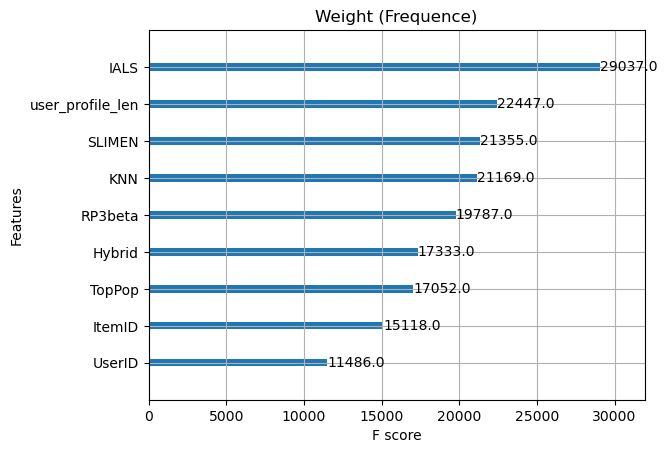

In [87]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

# **Recreating predictions**

In [88]:
item_popularity_encoded = np.ediff1d(URM_all.tocsc().indptr)
item_popularity_encoded = np.sort(item_popularity_encoded)

target_users = pd.read_csv("Dataset/data_target_users_test.csv")
target_users.columns = ["UserID"]

tar_users = target_users["UserID"].astype(int)
topPop_encoded = item_popularity_encoded[-10:]

In [123]:
orig_recs = candidate_generator_recommender.recommend(X_train["UserID"].astype(int).unique(), cutoff=cutoff)  # Example ID array

In [147]:
submission = []

def recommend(model, user_id):
    X_to_predict = X_train[X_train["UserID"] == user_id]
    #print(f"user_id: {user_id}")
    ids = candidate_generator_recommender.recommend(user_id, cutoff=cutoff)  # Example ID array
    scores = model.predict(X_to_predict)   # Corresponding scores array

    assert len(ids) == len(scores)

    # Pair each ID with its score and sort
    paired_sorted = sorted(zip(scores, ids), reverse=True)

    # Extract IDs from the sorted pairs
    sorted_ids = np.array(paired_sorted)[:, 1].astype(int)

    return sorted_ids

def fast_recommend(model, user_id):
    X_to_predict = X_train[X_train["UserID"] == user_id]
    #print(f"user_id: {user_id}")
    #ids = candidate_generator_recommender.recommend(user_id, cutoff=cutoff)  # Example ID array
    ids = orig_recs[user_id][:cutoff]
    scores = model.predict(X_to_predict)   # Corresponding scores array

    assert len(ids) == len(scores)

    # Pair each ID with its score and sort
    paired_sorted = sorted(zip(scores, ids), reverse=True)

    # Extract IDs from the sorted pairs
    sorted_ids = np.array(paired_sorted)[:, 1].astype(int)

    return sorted_ids

In [145]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [148]:
def evaluate_algorithm(URM_test, recommender_object, at=10):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0

    for user_id in tqdm(range(URM_test.shape[0])):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = fast_recommend(recommender_object, user_id)[:at]
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

evaluate_algorithm(URM_test, XGB_model)

  6%|▋         | 811/12638 [00:46<11:16, 17.48it/s]


KeyboardInterrupt: 

In [125]:
XGB_model.predict(X_train[X_train["UserID"]==1])

array([ 1.4973261,  1.7464372, -2.8675528, -2.3219712, -2.9717085,
       -2.252039 , -4.054305 , -2.248769 , -3.2570522, -3.1334364,
       -3.6802034, -2.8623433, -4.295009 ,  1.6216875, -3.4563382],
      dtype=float32)

In [127]:
for index, user in tqdm(enumerate(tar_users)):
    if (user not in df["UserID"].values):
        item_list_encoded = topPop_encoded
    else:
        item_list_encoded = fast_recommend(XGB_model, user2user_encoded[user])[:10]
    item_list = []
    for item_encoded in item_list_encoded:
        item_list.append(item_encoded2item[item_encoded])
    submission.append((user, item_list))

1160it [01:16, 15.17it/s]


KeyboardInterrupt: 

In [ ]:

def write_submission(submissions):
    with open("./submission_xgboost2.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")
            
write_submission(submission)